Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/classification-bank-marketing-all-features/auto-ml-classification-bank-marketing.png)

# Automated Machine Learning
_**Classification with Deployment using a Bank Marketing Dataset**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Train](#Train)
1. [Results](#Results)
1. [Deploy](#Deploy)
1. [Test](#Test)
1. [Acknowledgements](#Acknowledgements)

## Introduction

In this example we use the UCI Bank Marketing dataset to showcase how you can use AutoML for a  classification problem and deploy it to an Azure Container Instance (ACI). The classification goal is to predict if the client will subscribe to a term deposit with the bank.

If you are using an Azure Machine Learning Notebook VM, you are all set.  Otherwise, go through the [configuration](../../../configuration.ipynb)  notebook first if you haven't already to establish your connection to the AzureML Workspace. 

Please find the ONNX related documentations [here](https://github.com/onnx/onnx).

In this notebook you will learn how to:
1. Create an experiment using an existing workspace.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using local compute with ONNX compatible config on.
4. Explore the results, featurization transparency options and save the ONNX model
5. Inference with the ONNX model.
6. Register the model.
7. Create a container image.
8. Create an Azure Container Instance (ACI) service.
9. Test the ACI service.

In addition this notebook showcases the following features
- **Blacklisting** certain pipelines
- Specifying **target metrics** to indicate stopping criteria
- Handling **missing data** in the input

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [30]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.explain.model._internal.explanation_client import ExplanationClient

Accessing the Azure ML workspace requires authentication with Azure.

The default authentication is interactive authentication using the default tenant.  Executing the `ws = Workspace.from_config()` line in the cell below will prompt for authentication the first time that it is run.

If you have multiple Azure tenants, you can specify the tenant by replacing the `ws = Workspace.from_config()` line in the cell below with the following:

```
from azureml.core.authentication import InteractiveLoginAuthentication
auth = InteractiveLoginAuthentication(tenant_id = 'mytenantid')
ws = Workspace.from_config(auth = auth)
```

If you need to run in an environment where interactive login is not possible, you can use Service Principal authentication by replacing the `ws = Workspace.from_config()` line in the cell below with the following:

```
from azureml.core.authentication import ServicePrincipalAuthentication
auth = auth = ServicePrincipalAuthentication('mytenantid', 'myappid', 'mypassword')
ws = Workspace.from_config(auth = auth)
```
For more details, see [aka.ms/aml-notebook-auth](http://aka.ms/aml-notebook-auth)

In [31]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'automl-classification-bmarketing-all'

experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.83
Subscription ID,b208dd3b-2592-4e14-a626-cd6941369193
Workspace,mldemo
Resource Group,sqlserverkonferenz2020
Location,northeurope
Experiment Name,automl-classification-bmarketing-all


## Create or Attach existing AmlCompute
You will need to create a compute target for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.
#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [32]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "cpu-cluster-4"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
    
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D2_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                max_nodes = 6)

    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
print('Checking cluster status...')
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)
    
# For a more detailed view of current AmlCompute status, use get_status().

Found existing compute target.
Checking cluster status...
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


# Data

### Load Data

Leverage azure compute to load the bank marketing dataset as a Tabular Dataset into the dataset variable. 

### Training Data

In [33]:
data = pd.read_csv("https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,1,999,1,failure,-1.80,92.89,-46.20,1.30,5099.10,no
1,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,1,999,1,failure,-1.80,92.89,-46.20,1.31,5099.10,no
3,36,admin.,married,high.school,no,no,no,telephone,jun,fri,...,4,999,0,nonexistent,1.40,94.47,-41.80,4.97,5228.10,no
4,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no


In [34]:
# Add missing values in 75% of the lines.
import numpy as np

missing_rate = 0.75
n_missing_samples = int(np.floor(data.shape[0] * missing_rate))
missing_samples = np.hstack((np.zeros(data.shape[0] - n_missing_samples, dtype=np.bool), np.ones(n_missing_samples, dtype=np.bool)))
rng = np.random.RandomState(0)
rng.shuffle(missing_samples)
missing_features = rng.randint(0, data.shape[1], n_missing_samples)
data.values[np.where(missing_samples)[0], missing_features] = np.nan

In [35]:
if not os.path.isdir('data'):
    os.mkdir('data')
    
# Save the train data to a csv to be uploaded to the datastore
pd.DataFrame(data).to_csv("data/train_data.csv", index=False)

ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='bankmarketing', overwrite=True, show_progress=True)

 

# Upload the training data as a tabular dataset for access during training on remote compute
train_data = Dataset.Tabular.from_delimited_files(path=ds.path('bankmarketing/train_data.csv'))
label = "y"

Uploading an estimated of 1 files
Uploading ./data/train_data.csv
Uploaded ./data/train_data.csv, 1 files out of an estimated total of 1
Uploaded 1 files


In [36]:
# Register the train dataset with your workspace
train_data.register(workspace = ws, name = 'bankmarketing_train_dataset',
                       description = 'bank marketing training data',
                      create_new_version=True)

{
  "source": [
    "('workspaceblobstore', 'bankmarketing/train_data.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "2d9e080d-f3b7-44ad-9ac0-726d2a203934",
    "name": "bankmarketing_train_dataset",
    "version": 1,
    "description": "bank marketing training data",
    "workspace": "Workspace.create(name='mldemo', subscription_id='b208dd3b-2592-4e14-a626-cd6941369193', resource_group='sqlserverkonferenz2020')"
  }
}

### Validation Data

In [37]:
validation_data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_validate.csv"
validation_dataset = Dataset.Tabular.from_delimited_files(validation_data)

# Register the validation dataset with your workspace
validation_dataset.register(workspace = ws, name = 'bankmarketing_validation_dataset',
                       description = 'bank marketing validation data',
                       create_new_version=True)

{
  "source": [
    "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_validate.csv"
  ],
  "definition": [
    "GetFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "d468c5d6-c528-4735-9275-ddb81d9948fb",
    "name": "bankmarketing_validation_dataset",
    "version": 1,
    "description": "bank marketing validation data",
    "workspace": "Workspace.create(name='mldemo', subscription_id='b208dd3b-2592-4e14-a626-cd6941369193', resource_group='sqlserverkonferenz2020')"
  }
}

### Test Data

In [38]:
test_data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_test.csv"
test_dataset = Dataset.Tabular.from_delimited_files(test_data)

# Register the test dataset with your workspace
test_dataset.register(workspace = ws, name = 'bankmarketing_test_dataset',
                       description = 'bank marketing test data',
                       create_new_version=True)

{
  "source": [
    "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_test.csv"
  ],
  "definition": [
    "GetFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "135200c3-c3be-4251-881f-45cbda3424c5",
    "name": "bankmarketing_test_dataset",
    "version": 1,
    "description": "bank marketing test data",
    "workspace": "Workspace.create(name='mldemo', subscription_id='b208dd3b-2592-4e14-a626-cd6941369193', resource_group='sqlserverkonferenz2020')"
  }
}

## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression or forecasting|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**blacklist_models** | *List* of *strings* indicating machine learning algorithms for AutoML to avoid in this run. <br><br> Allowed values for **Classification**<br><i>LogisticRegression</i><br><i>SGD</i><br><i>MultinomialNaiveBayes</i><br><i>BernoulliNaiveBayes</i><br><i>SVM</i><br><i>LinearSVM</i><br><i>KNN</i><br><i>DecisionTree</i><br><i>RandomForest</i><br><i>ExtremeRandomTrees</i><br><i>LightGBM</i><br><i>GradientBoosting</i><br><i>TensorFlowDNN</i><br><i>TensorFlowLinearClassifier</i><br><br>Allowed values for **Regression**<br><i>ElasticNet</i><br><i>GradientBoosting</i><br><i>DecisionTree</i><br><i>KNN</i><br><i>LassoLars</i><br><i>SGD</i><br><i>RandomForest</i><br><i>ExtremeRandomTrees</i><br><i>LightGBM</i><br><i>TensorFlowLinearRegressor</i><br><i>TensorFlowDNN</i><br><br>Allowed values for **Forecasting**<br><i>ElasticNet</i><br><i>GradientBoosting</i><br><i>DecisionTree</i><br><i>KNN</i><br><i>LassoLars</i><br><i>SGD</i><br><i>RandomForest</i><br><i>ExtremeRandomTrees</i><br><i>LightGBM</i><br><i>TensorFlowLinearRegressor</i><br><i>TensorFlowDNN</i><br><i>Arima</i><br><i>Prophet</i>|
| **whitelist_models** |  *List* of *strings* indicating machine learning algorithms for AutoML to use in this run. Same values listed above for **blacklist_models** allowed for **whitelist_models**.|
|**experiment_exit_score**| Value indicating the target for *primary_metric*. <br>Once the target is surpassed the run terminates.|
|**experiment_timeout_hours**| Maximum amount of time in hours that all iterations combined can take before the experiment terminates.|
|**enable_early_stopping**| Flag to enble early termination if the score is not improving in the short term.|
|**featurization**| 'auto' / 'off'  Indicator for whether featurization step should be done automatically or not. Note: If the input data is sparse, featurization cannot be turned on.|
|**n_cross_validations**|Number of cross validation splits.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**model_explainability**|Indicate to explain each trained pipeline or not.|

**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

In [39]:
automl_settings = {
    "experiment_timeout_hours" : 0.3,
    "enable_early_stopping" : True,
    "iteration_timeout_minutes": 5,
    "max_concurrent_iterations": 4,
    "max_cores_per_iteration": -1,
    #"n_cross_validations": 2,
    "primary_metric": 'AUC_weighted',
    "featurization": 'auto',
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target=compute_target,
                             experiment_exit_score = 0.9984,
                             blacklist_models = ['KNN','LinearSVM'],
                             enable_onnx_compatible_models=True,
                             training_data = train_data,
                             label_column_name = label,
                             validation_data = validation_dataset,
                             model_explainability=True,
                             **automl_settings
                            )

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.

In [40]:
remote_run = experiment.submit(automl_config, show_output = False)

In [41]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification-bmarketing-all,AutoML_4da9cdee-b4dc-466f-93c0-bc7bae7d37f0,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


Run the following cell to access previous runs. Uncomment the cell below and update the run_id.

In [42]:
#from azureml.train.automl.run import AutoMLRun
#experiment_name = 'automl-classification-bmarketing'
#experiment = Experiment(ws, experiment_name)
#remote_run = AutoMLRun(experiment=experiment, run_id='<run_ID_goes_here')
#remote_run

In [43]:
# Wait for the remote run to complete
remote_run.wait_for_completion()

{'runId': 'AutoML_4da9cdee-b4dc-466f-93c0-bc7bae7d37f0',
 'target': 'cpu-cluster-4',
 'status': 'Completed',
 'startTimeUtc': '2020-03-02T09:10:43.196909Z',
 'endTimeUtc': '2020-03-02T09:31:38.81142Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'MaxTimeSeconds': '300',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'cpu-cluster-4',
  'RawAMLSettingsString': "{'name': 'automl-classification-bmarketing-all', 'path': None, 'subscription_id': 'b208dd3b-2592-4e14-a626-cd6941369193', 'resource_group': 'sqlserverkonferenz2020', 'workspace_name': 'mldemo', 'region': 'northeurope', 'compute_target': 'cpu-cluster-4', 'spark_service': None, 'azure_service': None, 'iterations': 1000, 'primary_metric': 'AUC_weighted', 'task_type': 'classification', 'data_script': None, 'validation_size': 0.0, 'n_cross_validations': None, 'y_min': None, 'y_max': None

In [44]:
best_run_customized, fitted_model_customized = remote_run.get_output()

## Transparency

View updated featurization summary

In [45]:
custom_featurizer = fitted_model_customized.named_steps['datatransformer']
df = custom_featurizer.get_featurization_summary()
pd.DataFrame(data=df)

,Dropped,EngineeredFeatureCount,RawFeatureName,Transformations,TypeDetected
0,No,1,age,[MeanImputer],Numeric
1,No,1,duration,[MeanImputer],Numeric
2,No,1,emp.var.rate,[MeanImputer],Numeric
3,No,1,cons.price.idx,[MeanImputer],Numeric
4,No,1,cons.conf.idx,[MeanImputer],Numeric
5,No,1,euribor3m,[MeanImputer],Numeric
6,No,1,nr.employed,[MeanImputer],Numeric
7,No,12,job,[StringCast-CharGramCountVectorizer],Categorical
8,No,4,marital,[StringCast-CharGramCountVectorizer],Categorical
9,No,8,education,[StringCast-CharGramCountVectorizer],Categorical


Set `is_user_friendly=False` to get a more detailed summary for the transforms being applied.

In [46]:
df = custom_featurizer.get_featurization_summary(is_user_friendly=False)
pd.DataFrame(data=df)

,Dropped,EngineeredFeatureCount,RawFeatureName,TransformationParams,Transformations,TypeDetected
0,No,1,age,"{'Transformer1': {'Input': ['age'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
1,No,1,duration,"{'Transformer1': {'Input': ['duration'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
2,No,1,emp.var.rate,"{'Transformer1': {'Input': ['emp.var.rate'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
3,No,1,cons.price.idx,"{'Transformer1': {'Input': ['cons.price.idx'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
4,No,1,cons.conf.idx,"{'Transformer1': {'Input': ['cons.conf.idx'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
5,No,1,euribor3m,"{'Transformer1': {'Input': ['euribor3m'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
6,No,1,nr.employed,"{'Transformer1': {'Input': ['nr.employed'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
7,No,12,job,"{'Transformer1': {'Input': ['job'], 'TransformationFunction': 'StringCast', 'Operator': None, 'FeatureType': 'Categorical', 'ShouldOutput': False, 'TransformationParams': None}, 'Transformer2': {'Input': ['Transformer1'], 'TransformationFunction': 'CountVectorizer', 'Operator': 'CharGram', 'FeatureType': None, 'ShouldOutput': True, 'TransformationParams': {'analyzer': 'word', 'binary': True, 'decode_error': 'strict', 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\b\w\w+\b', 'vocabulary': None}}}",[StringCast-CharGramCountVectorizer],Categorical
8,No,4,marital,"{'Transformer1': {'Input': ['marital'], 'TransformationFunction': 'StringCast', 'Operator': None, 'FeatureType': 'Categorical', 'ShouldOutput': False, 'TransformationParams': None}, 'Transformer2': {'Input': ['Transformer1'], 'TransformationFunction': 'CountVectorizer', 'Operator': 'CharGram', 'FeatureType': None, 'ShouldOutput': True, 'TransformationParams': {'analyzer': 'word', 'binary': True, 'decode_error': 'strict', 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\b\w\w+\b', 'vocabulary': None}}}",[StringCast-CharGramCountVectorizer],Categorical
9,No,8,education,"{'Transformer1': {'Input': ['education'], 'TransformationFunction': 'StringCast', 'Operator': None, 'FeatureType': 'Categorical', 'ShouldOutput': False, 'TransformationParams': None}, 'Transformer2': {'Input': ['Transformer1'], 'TransformationFunction': 'CountVectorizer', 'Operator': 'CharGram', 'FeatureType': None, 'ShouldOutput': True,

In [47]:
df = custom_featurizer.get_stats_feature_type_summary()
pd.DataFrame(data=df)

,column name,feature type,statistic
0,age,Numeric,"{""num_unique_vals"": 77, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""integer"", ""num_unique_lens"": 0, ""average_entry_length"": 0, ""average_number_spaces"": 0, ""cardinality_ratio"": 0, ""is_datetime"": false, ""is_all_nan"": false}"
1,job,Categorical,"{""num_unique_vals"": 12, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 8, ""average_entry_length"": 8.955842185128983, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 0.0003641881638846737, ""is_datetime"": false, ""is_all_nan"": false}"
2,marital,Categorical,"{""num_unique_vals"": 4, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 3, ""average_entry_length"": 6.831077389984825, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 0.00012139605462822458, ""is_datetime"": false, ""is_all_nan"": false}"
3,education,Categorical,"{""num_unique_vals"": 8, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 6, ""average_entry_length"": 12.712139605462822, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 0.00024279210925644916, ""is_datetime"": false, ""is_all_nan"": false}"
4,default,Categorical,"{""num_unique_vals"": 3, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 3, ""average_entry_length"": 3.0445523520485582, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 9.104704097116843e-05, ""is_datetime"": false, ""is_all_nan"": false}"
5,housing,Categorical,"{""num_unique_vals"": 3, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 3, ""average_entry_length"": 2.641638846737481, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 9.104704097116843e-05, ""is_datetime"": false, ""is_all_nan"": false}"
6,loan,Categorical,"{""num_unique_vals"": 3, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 3, ""average_entry_length"": 2.2704704097116846, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 9.104704097116843e-05, ""is_datetime"": false, ""is_all_nan"": false}"
7,contact,Categorical,"{""num_unique_vals"": 2, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 2, ""average_entry_length"": 8.364309559939302, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 6.069802731411229e-05, ""is_datetime"": false, ""is_all_nan"": false}"
8,month,Categorical,"{""num_unique_vals"": 10, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 1, ""average_entry_length"": 3.0, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 0.00030349013657056146, ""is_datetime"": false, ""is_all_nan"": false}"
9,day_of_week,Categorical,"{""num_unique_vals"": 5, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 1, ""average_entry_length"": 3.0, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 0.00015174506828528073, ""is_datetime"": false, ""is_all_nan"": false}"


## Results

In [48]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### Retrieve the Best Model's explanation
Retrieve the explanation from the best_run which includes explanations for engineered features and raw features. Make sure that the run for generating explanations for the best model is completed.

In [49]:
# Wait for the best model explanation run to complete
from azureml.train.automl.run import AutoMLRun
model_explainability_run_id = remote_run.get_properties().get('ModelExplainRunId')
print(model_explainability_run_id)
if model_explainability_run_id is not None:
    model_explainability_run = AutoMLRun(experiment=experiment, run_id=model_explainability_run_id)
    model_explainability_run.wait_for_completion()

# Get the best run object
best_run, fitted_model = remote_run.get_output()

AutoML_4da9cdee-b4dc-466f-93c0-bc7bae7d37f0_ModelExplain


#### Download engineered feature importance from artifact store
You can use ExplanationClient to download the engineered feature explanations from the artifact store of the best_run.

In [50]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

Exception: Did not find any explanations for run AutoML_4da9cdee-b4dc-466f-93c0-bc7bae7d37f0_0

#### Download raw feature importance from artifact store
You can use ExplanationClient to download the raw feature explanations from the artifact store of the best_run.

In [51]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=True)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'duration': 1.0161966945858565,
 'nr.employed': 0.5117161209353319,
 'emp.var.rate': 0.23883474109640812,
 'cons.conf.idx': 0.21316080092048123,
 'euribor3m': 0.168620804014605,
 'cons.price.idx': 0.07304425646687139,
 'poutcome': 0.06509708150177825,
 'month': 0.04376299074928069,
 'age': 0.043455252568287445,
 'day_of_week': 0.04000109936643055,
 'pdays': 0.03949910684993991,
 'default': 0.03517740410853412,
 'job': 0.031035802473665743,
 'education': 0.02839188192887642,
 'campaign': 0.02341470988339365,
 'contact': 0.016618027367997317,
 'previous': 0.009727563527980453,
 'housing': 0.0015215340367300272,
 'marital': 0.00041127710753354764,
 'loan': 0.00020846973826103358}

### Retrieve the Best ONNX Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

Set the parameter return_onnx_model=True to retrieve the best ONNX model, instead of the Python model.

In [52]:
best_run, onnx_mdl = remote_run.get_output(return_onnx_model=True)

### Save the best ONNX model

In [53]:
from azureml.automl.runtime.onnx_convert import OnnxConverter
onnx_fl_path = "./best_model.onnx"
OnnxConverter.save_onnx_model(onnx_mdl, onnx_fl_path)

### Predict with the ONNX model, using onnxruntime package

In [54]:
import sys
import json
from azureml.automl.core.onnx_convert import OnnxConvertConstants
from azureml.train.automl import constants

if sys.version_info < OnnxConvertConstants.OnnxIncompatiblePythonVersion:
    python_version_compatible = True
else:
    python_version_compatible = False

import onnxruntime
from azureml.automl.runtime.onnx_convert import OnnxInferenceHelper

def get_onnx_res(run):
    res_path = 'onnx_resource.json'
    run.download_file(name=constants.MODEL_RESOURCE_PATH_ONNX, output_file_path=res_path)
    with open(res_path) as f:
        onnx_res = json.load(f)
    return onnx_res

if python_version_compatible:
    test_df = test_dataset.to_pandas_dataframe()
    mdl_bytes = onnx_mdl.SerializeToString()
    onnx_res = get_onnx_res(best_run)

    onnxrt_helper = OnnxInferenceHelper(mdl_bytes, onnx_res)
    pred_onnx, pred_prob_onnx = onnxrt_helper.predict(test_df)

    print(pred_onnx)
    print(pred_prob_onnx)
else:
    print('Please use Python version 3.6 or 3.7 to run the inference helper.')

None
None


## Deploy

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method on `automl_classifier` returns the best run and the fitted model for the last invocation. Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [55]:
best_run, fitted_model = remote_run.get_output()

In [56]:
model_name = best_run.properties['model_name']

script_file_name = 'inference/score.py'
conda_env_file_name = 'inference/env.yml'

best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'inference/score.py')
best_run.download_file('outputs/conda_env_v_1_0_0.yml', 'inference/env.yml')

### Register the Fitted Model for Deployment
If neither `metric` nor `iteration` are specified in the `register_model` call, the iteration with the best primary metric is registered.

In [57]:
description = 'AutoML Model trained on bank marketing data to predict if a client will subscribe to a term deposit'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id) # This will be written to the script file later in the notebook.

AutoML4da9cdeeb0


### Deploy the model as a Web Service on Azure Container Instance

In [58]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

myenv = Environment.from_conda_specification(name="myenv", file_path=conda_env_file_name)
inference_config = InferenceConfig(entry_script=script_file_name, environment=myenv)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "bmData", 'type': "automl_classification"}, 
                                               description = 'sample service for Automl Classification')

aci_service_name = 'automl-sample-bankmarketing-all'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-sample-bankmarketing-all
Running.........................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


### Delete a Web Service

Deletes the specified web service.

In [ ]:
#aci_service.delete()

### Get Logs from a Deployed Web Service

Gets logs from a deployed web service.

In [64]:
aci_service.get_logs()

'2020-03-02T10:02:35,116939159+00:00 - iot-server/run \n2020-03-02T10:02:35,117450859+00:00 - gunicorn/run \n2020-03-02T10:02:35,117021559+00:00 - rsyslog/run \n2020-03-02T10:02:35,227958789+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_fbcfb8bb99b0dbe12902d1eedf1c3f3c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_fbcfb8bb99b0dbe12902d1eedf1c3f3c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_fbcfb8bb99b0dbe12902d1eedf1c3f3c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_fbcfb8bb99b0dbe12902d1eedf1c3f3c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_fbcfb8bb99b0dbe12902d1eedf1c3f3c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

## Test

Now that the model is trained, run the test data through the trained model to get the predicted values.

In [59]:
# Load the bank marketing datasets.
from numpy import array

In [60]:
X_test = test_dataset.drop_columns(columns=['y'])
y_test = test_dataset.keep_columns(columns=['y'], validate=True)
test_dataset.take(5).to_pandas_dataframe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,51,retired,married,basic.4y,no,no,no,cellular,jul,wed,...,1,13,1,success,-2.90,92.47,-33.60,1.08,5076.20,no
1,53,self-employed,divorced,university.degree,no,no,no,cellular,jul,mon,...,3,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
2,32,services,married,basic.9y,no,no,no,cellular,jul,tue,...,1,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
3,44,management,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.10,93.20,-42.00,4.19,5195.80,no
4,36,admin.,single,university.degree,no,no,no,cellular,may,fri,...,3,999,1,failure,-1.80,92.89,-46.20,1.31,5099.10,no


In [61]:
X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()

In [62]:
y_pred  = fitted_model.predict(X_test)
actual = array(y_test)
actual = actual[:,0]
print(y_pred.shape, " ", actual.shape)

(4120,)   (4120,)


### Calculate metrics for the prediction

Now visualize the data on a scatter plot to show what our truth (actual) values are compared to the predicted values 
from the trained model that was returned.

<IPython.core.display.Javascript object>


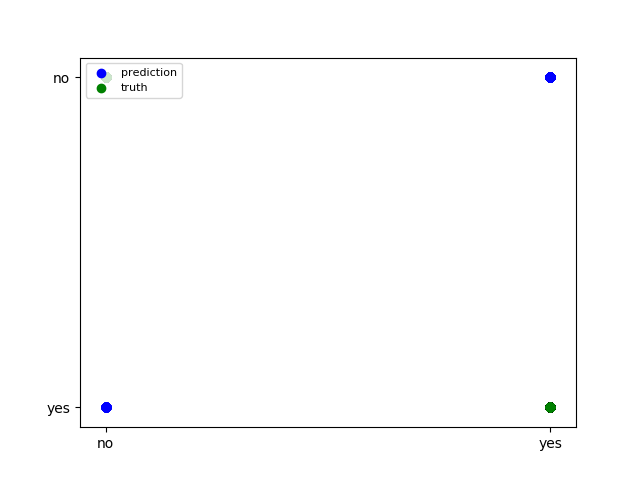

In [63]:
%matplotlib notebook
test_pred = plt.scatter(actual, y_pred, color='b')
test_test = plt.scatter(actual, actual, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

## Acknowledgements

This Bank Marketing dataset is made available under the Creative Commons (CCO: Public Domain) License: https://creativecommons.org/publicdomain/zero/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: https://creativecommons.org/publicdomain/zero/1.0/ and is available at: https://www.kaggle.com/janiobachmann/bank-marketing-dataset .

_**Acknowledgements**_
This data set is originally available within the UCI Machine Learning Database: https://archive.ics.uci.edu/ml/datasets/bank+marketing

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014